In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from PIL import Image
from glob import glob

In [ ]:
!apt-get install unrar
import os
os.makedirs("/content/dataset", exist_ok=True)

!unrar x "/content/drive/MyDrive/currency/dataset/money_dataset.rar" "/content/dataset"

In [ ]:
from tqdm import tqdm
import cv2
class PreprocessDataset():
    def __init__(self, dataset_path, output_path, train_split, val_split, test_split):
        self.dataset_path = dataset_path
        self.output_path = output_path
        self.train_split = train_split
        self.val_split = val_split
        self.test_split = test_split

        if round(self.train_split + self.val_split + self.test_split, 2) != 1.0:
            raise ValueError("Sum of Train, Validation, and Test splits must be 1.")

        if not os.path.exists(self.output_path):
            os.mkdir(self.output_path)
            os.mkdir(os.path.join(self.output_path, 'train'))
            os.mkdir(os.path.join(self.output_path, 'val'))
            os.mkdir(os.path.join(self.output_path, 'test'))

    def read_image(self, folder_path, image_path, directory_type):
        img = cv2.imread(os.path.join(folder_path, image_path))
        cv2.imwrite(os.path.join(self.output_path, directory_type, image_path), img)

    def convertPath(self):
        folders = sorted([folder for folder in os.listdir(self.dataset_path) if not folder.endswith('data')])
        for folder in folders:
            folder_path = os.path.join(self.dataset_path, folder)
            images = os.listdir(folder_path)
            total_images = len(images)
            train_size = int(self.train_split * total_images)
            val_size = int(self.val_split * total_images)

            train_set = images[:train_size]
            val_set = images[train_size:(train_size + val_size)]
            test_set = images[(train_size + val_size):]

            for split_type in ['train', 'val', 'test']:
                dir_path = os.path.join(self.output_path, split_type, folder)
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)

            with tqdm(total=len(train_set), desc=f'Training set ({folder} vnd)') as pbar:
                for img in train_set:
                    self.read_image(folder_path, img, f'train/{folder}')
                    pbar.update(1)

            with tqdm(total=len(val_set), desc=f'Validation set ({folder} vnd)') as pbar:
                for img in val_set:
                    self.read_image(folder_path, img, f'val/{folder}')
                    pbar.update(1)

            with tqdm(total=len(test_set), desc=f'Test set ({folder} vnd)') as pbar:
                for img in test_set:
                    self.read_image(folder_path, img, f'test/{folder}')
                    pbar.update(1)

            print('\n')

# Sử dụng
vietnamese_currency = PreprocessDataset(
    dataset_path='/content/dataset/money_dataset/dataset',
    output_path='/content/currency_processed',
    train_split=0.75,
    val_split=0.15,
    test_split=0.10
)

vietnamese_currency.convertPath()

TRỰC QUAN DỮ LIỆU

In [ ]:
from collections import defaultdict
import os
import matplotlib.pyplot as plt
target_base_dir="/content/currency_processed"
def get_class_counts(split_dir):
    counts = {}
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

train_counts = get_class_counts(os.path.join(target_base_dir, 'train'))
val_counts = get_class_counts(os.path.join(target_base_dir, 'val'))
test_counts = get_class_counts(os.path.join(target_base_dir, 'test'))


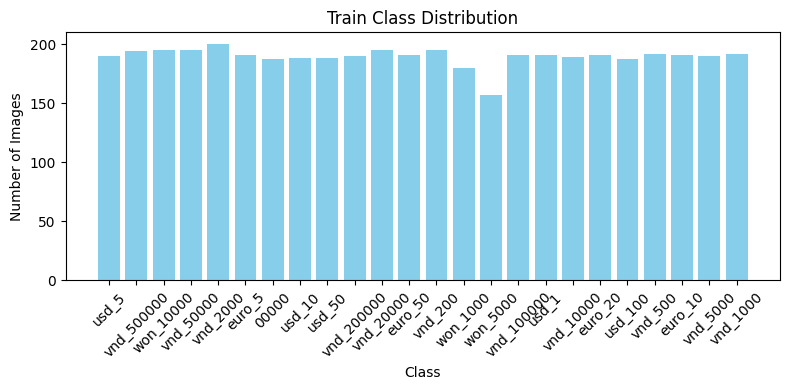

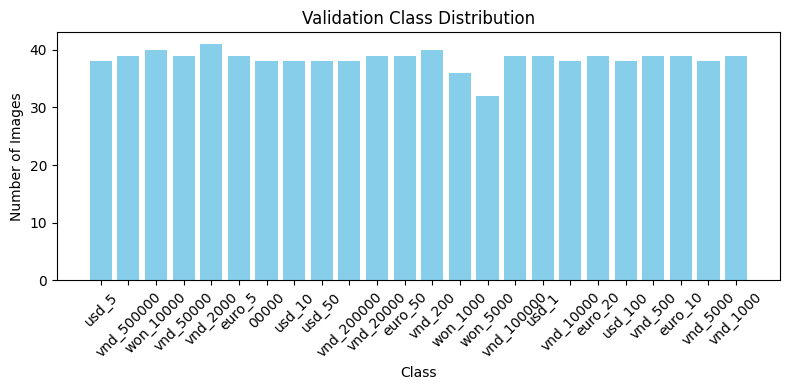

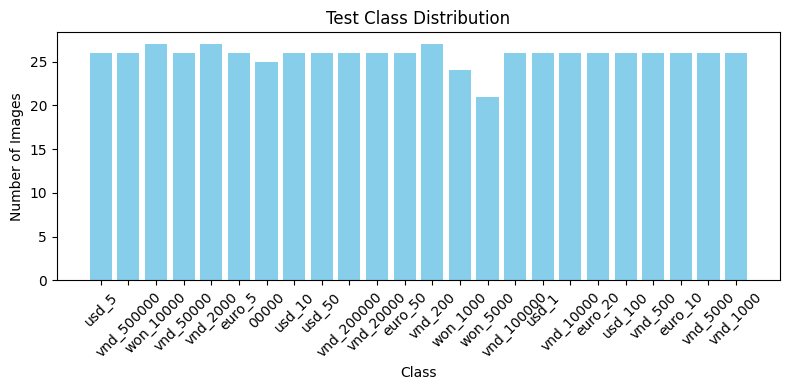

In [ ]:
def plot_class_distribution(counts_dict, title):
    classes = list(counts_dict.keys())
    counts = list(counts_dict.values())

    plt.figure(figsize=(8, 4))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_counts, "Train Class Distribution")
plot_class_distribution(val_counts, "Validation Class Distribution")
plot_class_distribution(test_counts, "Test Class Distribution")


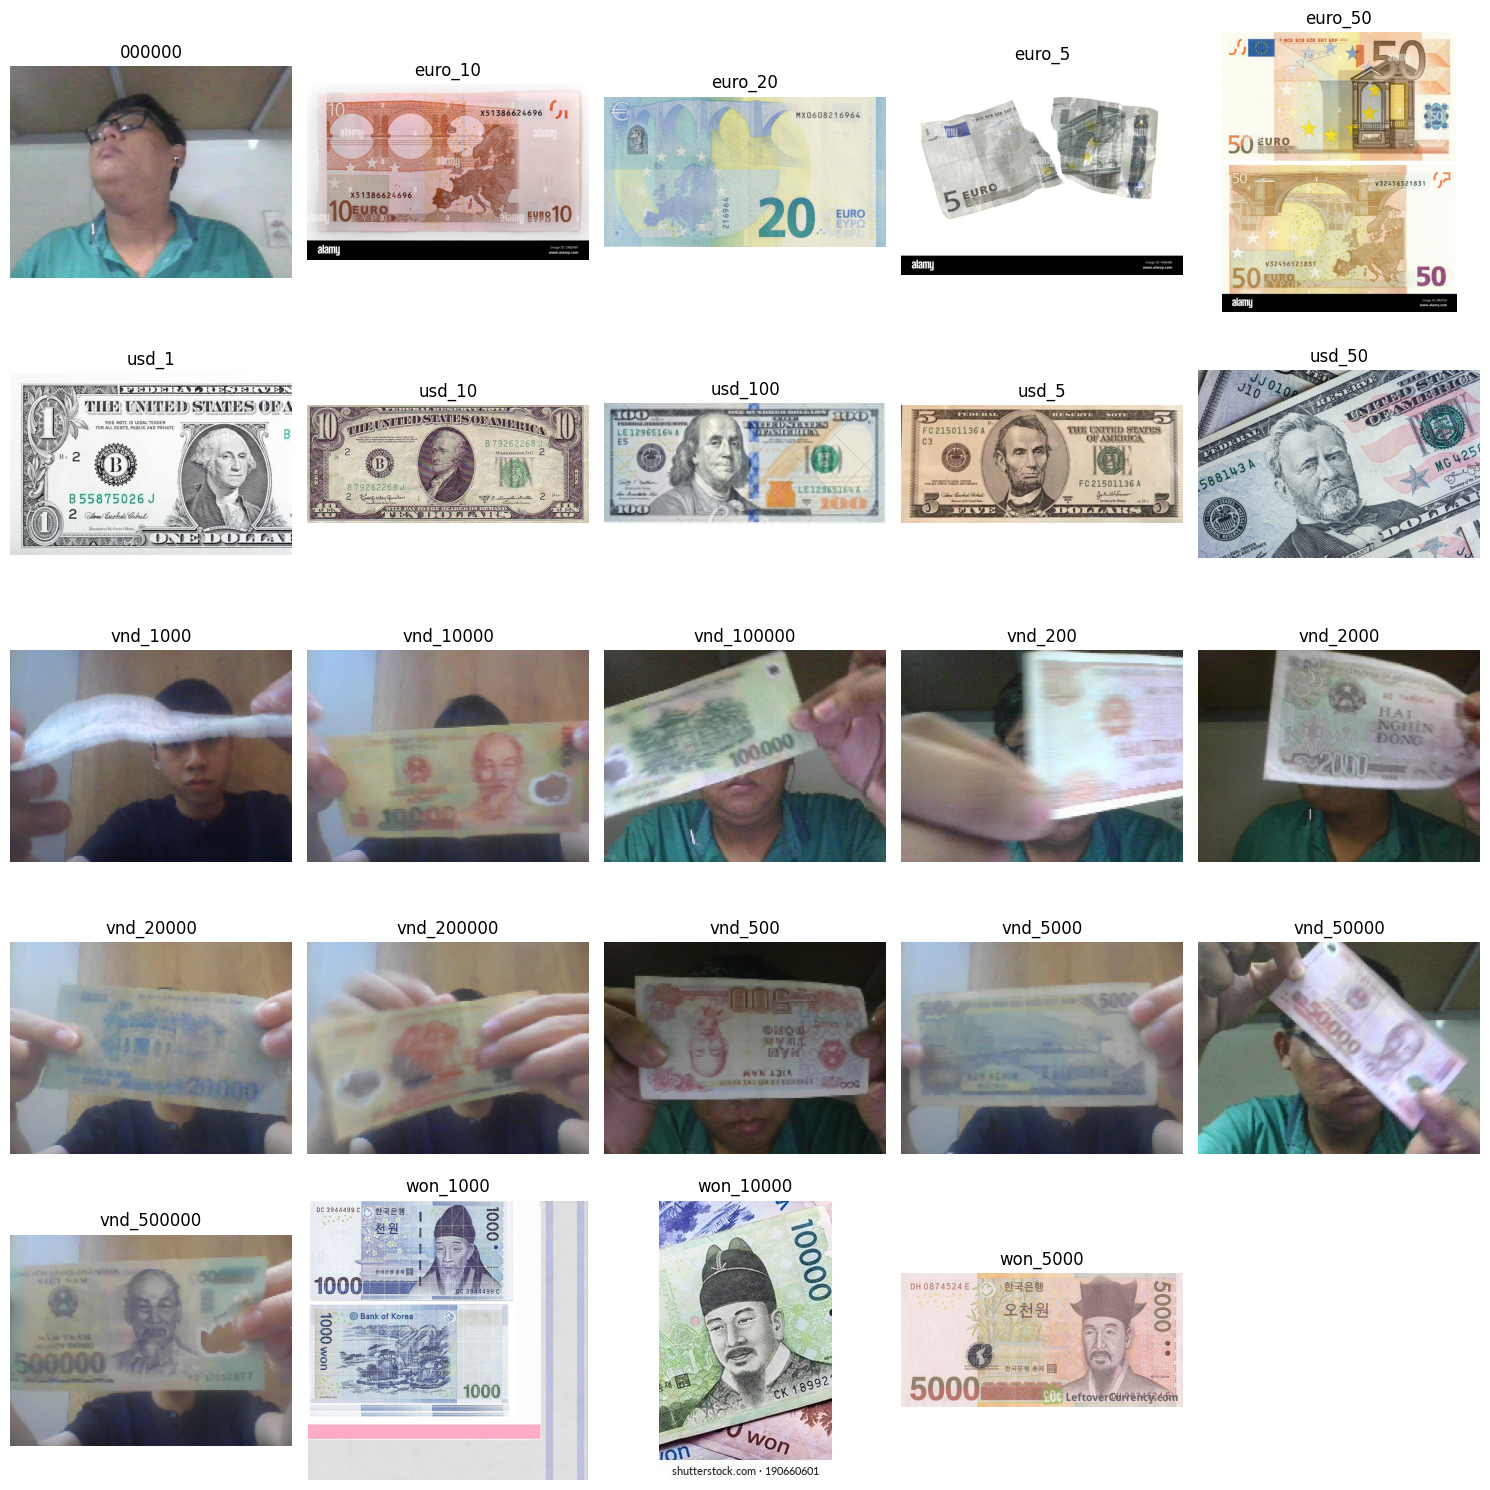

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

train_dir = os.path.join(target_base_dir, 'train')
class_names = sorted(os.listdir(train_dir))

num_classes = len(class_names)
cols = 5  # số cột muốn hiển thị
rows = math.ceil(num_classes / cols)  # tự tính số hàng cần thiết

plt.figure(figsize=(cols * 3, rows * 3))  # tăng kích thước phù hợp
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    img_name = os.listdir(class_path)[60]
    img_path = os.path.join(class_path, img_name)

    img = mpimg.imread(img_path)
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Thông số
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001
USE_AUGMENTATION = True
MODEL_PATH = 'mobilenetv2_model.pt'
REAL_IMAGE_DIR = ''  # đường dẫn ảnh thực tế nếu có

In [ ]:
from torchvision import transforms
DATA_DIR="/content/currency_processed"
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'val'), transform=test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'test'), transform=test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super().__init__()
        self.stride = stride
        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = (self.stride == 1 and inp == oup)

        layers = []
        if expand_ratio != 1:
            # Pointwise
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        # Depthwise
        layers.append(ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim))
        # Pointwise-linear
        layers.append(nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False))
        layers.append(nn.BatchNorm2d(oup))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=24, width_mult=1.0):
        super().__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280

        # t, c, n, s
        inverted_residual_setting = [
            [1,  16, 1, 1],
            [6,  24, 2, 2],
            [6,  32, 3, 2],
            [6,  64, 4, 2],
            [6,  96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) if width_mult > 1.0 else last_channel

        features = [ConvBNReLU(3, input_channel, stride=2)]
        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        self.features = nn.Sequential(*features)

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Khởi tạo mô hình
model = MobileNetV2(num_classes=24)
model = model.to(device)


In [ ]:
# Loss với label smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        log_probs = nn.functional.log_softmax(pred, dim=-1)
        true_dist = torch.zeros_like(log_probs).scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist += self.smoothing / pred.size(1)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Huấn luyện
train_acc, val_acc, train_loss, val_loss = [], [], [], []
best_val_acc = 0.0  # Sửa từ best_train_acc thành best_val_acc

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    epoch_train_acc = correct / len(train_loader.dataset)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)

    # Đánh giá trên tập validation
    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
    epoch_val_acc = val_correct / len(val_loader.dataset)
    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    val_acc.append(epoch_val_acc)
    val_loss.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}, Val_Loss: {epoch_val_loss:.4f}, Val_Acc: {epoch_val_acc:.4f}")

    # Lưu model nếu val acc tốt hơn
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        print(f" Đã lưu model tại epoch {epoch+1} với Val Acc tốt nhất: {best_val_acc:.4f}")


Epoch 1/20 - Loss: 2.3716, Acc: 0.2449, Val_Loss: 2.3213, Val_Acc: 0.2695
 Đã lưu model tại epoch 1 với Val Acc tốt nhất: 0.2695
Epoch 2/20 - Loss: 1.8166, Acc: 0.4569, Val_Loss: 1.6178, Val_Acc: 0.5675
 Đã lưu model tại epoch 2 với Val Acc tốt nhất: 0.5675
Epoch 3/20 - Loss: 1.5601, Acc: 0.6014, Val_Loss: 1.5126, Val_Acc: 0.6557
 Đã lưu model tại epoch 3 với Val Acc tốt nhất: 0.6557
Epoch 4/20 - Loss: 1.3061, Acc: 0.7335, Val_Loss: 1.2503, Val_Acc: 0.7689
 Đã lưu model tại epoch 4 với Val Acc tốt nhất: 0.7689
Epoch 5/20 - Loss: 1.1499, Acc: 0.8088, Val_Loss: 1.2498, Val_Acc: 0.7804
 Đã lưu model tại epoch 5 với Val Acc tốt nhất: 0.7804
Epoch 6/20 - Loss: 1.0601, Acc: 0.8489, Val_Loss: 0.9155, Val_Acc: 0.9136
 Đã lưu model tại epoch 6 với Val Acc tốt nhất: 0.9136
Epoch 7/20 - Loss: 0.9681, Acc: 0.8884, Val_Loss: 1.0437, Val_Acc: 0.8601
Epoch 8/20 - Loss: 0.9087, Acc: 0.9098, Val_Loss: 0.8889, Val_Acc: 0.9361
 Đã lưu model tại epoch 8 với Val Acc tốt nhất: 0.9361
Epoch 9/20 - Loss: 0.88

In [ ]:
# Đánh giá trên tập test
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.numpy())

print("Báo cáo phân loại:")
print(classification_report(all_labels, all_preds))

f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
print(f"F1-score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00        26
           3       1.00      0.96      0.98        28
           4       1.00      1.00      1.00        24
           5       0.98      0.98      0.98        59
           6       1.00      0.95      0.97        59
           7       1.00      0.98      0.99        58
           8       1.00      1.00      1.00        63
           9       0.96      1.00      0.98        69
          10       0.98      0.97      0.98        66
          11       0.97      0.97      0.97        66
          12       0.97      1.00      0.99        66
          13       1.00      1.00      1.00        26
          14       1.00      0.97      0.98        66
          15       0.96      0.93      0.95        56
          16       0.96      0.98      0.97        66
        

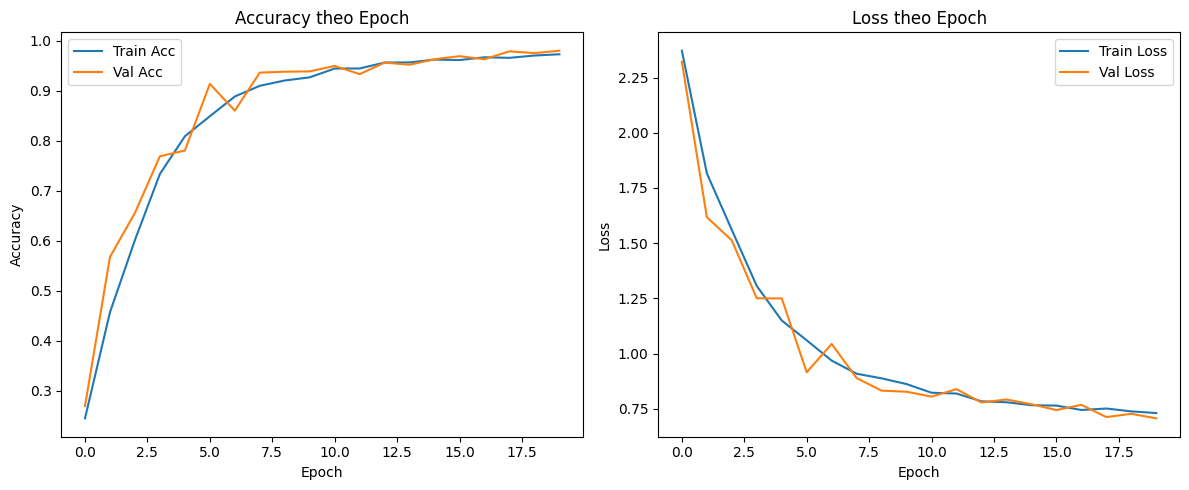

In [ ]:
# Biểu đồ
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy theo Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss theo Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Ảnh: Screenshot 2025-05-19 163255.png => Dự đoán: vnd_50000


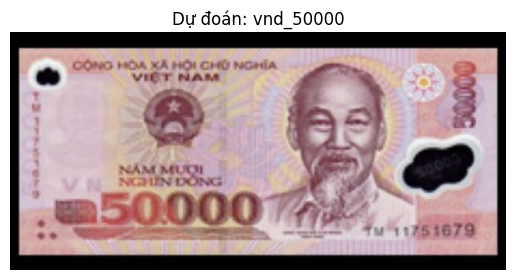

Ảnh: Screenshot 2025-05-19 162724.png => Dự đoán: won_10000


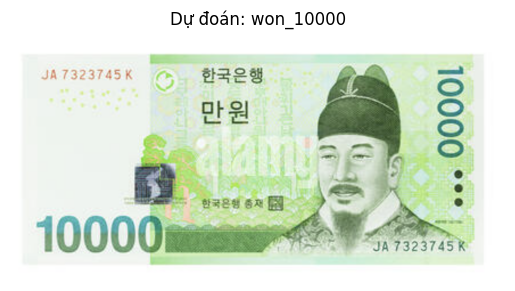

Ảnh: Screenshot 2025-05-17 145227.png => Dự đoán: euro_5


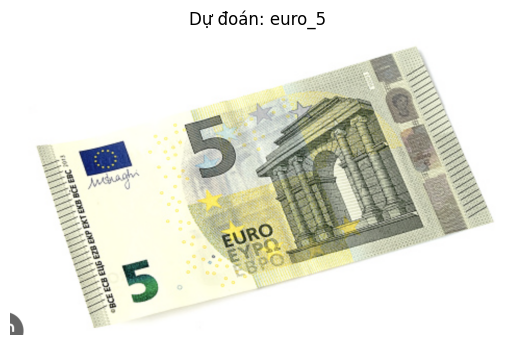

Ảnh: Screenshot 2025-05-16 211933.png => Dự đoán: euro_20


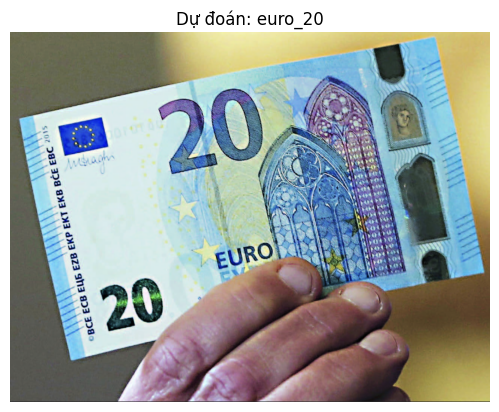

Ảnh: Screenshot 2025-05-16 212049.png => Dự đoán: won_1000


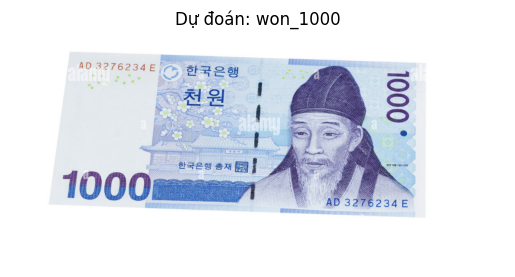

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Danh sách nhãn (sorted theo bạn cung cấp)
class_names = sorted([
    '000000', 'euro_10', 'euro_20', 'euro_5', 'euro_50',
    'usd_1', 'usd_10', 'usd_100', 'usd_5', 'usd_50',
    'vnd_1000', 'vnd_10000', 'vnd_100000', 'vnd_200', 'vnd_2000',
    'vnd_20000', 'vnd_200000', 'vnd_500', 'vnd_5000', 'vnd_50000',
    'vnd_500000', 'won_1000', 'won_10000', 'won_5000'
])

# Thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load model
model = MobileNetV2(num_classes=24).to(device)
model.load_state_dict(torch.load("/content/mobilenet_best (1).pth", map_location=device))
model.eval()

# Tiền xử lý ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # đảm bảo kích thước phù hợp
    transforms.ToTensor(),
])

# Đường dẫn thư mục test ảnh
test_folder = "/content/test"  # chỉnh đúng đường dẫn

# Duyệt qua tất cả ảnh trong thư mục
image_files = [f for f in os.listdir(test_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Dự đoán và hiển thị từng ảnh
for img_file in image_files:
    img_path = os.path.join(test_folder, img_file)
    try:
        image = Image.open(img_path).convert('RGB')
    except:
        print(f"Lỗi khi mở ảnh: {img_file}")
        continue

    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_label = class_names[predicted.item()]

    # In tên file và label dự đoán
    print(f"Ảnh: {img_file} => Dự đoán: {predicted_label}")

    # Hiển thị ảnh
    plt.imshow(image)
    plt.title(f"Dự đoán: {predicted_label}")
    plt.axis('off')
    plt.show()
